In [1]:
from math import *
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import json

import matplotlib.pyplot as plt

import skyfield
from skyfield.api import load
from skyfield.api import N, W, S, E, wgs84
from skyfield.api import Star
from skyfield.data import hipparcos
from skyfield.almanac import find_discrete, risings_and_settings

In [2]:
ts = load.timescale()
eph = load('de421.bsp')

sun = eph['sun']
mercury = eph['mercury']
venus = eph['venus']
earth = eph['earth']
mars = eph['mars']
jupiter = eph['JUPITER BARYCENTER']
moon = eph['moon']

with load.open(hipparcos.URL) as f:
    stars_df = hipparcos.load_dataframe(f)
    
star_dictionary = {"Alpheratz":677, "Ankaa":2081, "Schedar":3179, "Diphda":3419, "Achernar":7588, "Hamal":9884, "Polaris":11767, "Acamar":13847, "Menkar":14135, "Mirfak":15863, "Aldebaran":21421, "Rigel":24436, "Capella":24608, "Bellatrix":25336, "Elnath":25428, "Alnilam":26311, "Betelgeuse":27989, "Canopus":30438, "Sirius":32349, "Adhara":33579, "Procyon":37279, "Pollux":37826, "Avior":41037, "Suhail":44816, "Miaplacidus":45238, "Alphard":46390, "Regulus":49669, "Dubhe":54061, "Denebola":57632, "Gienah":59803, "Acrux":60718, "Gacrux":61084, "Alioth":62956, "Spica":65474, "Alkaid":67301, "Hadar":68702, "Menkent":68933, "Arcturus":69673, "Rigil Kent.":71683, "Kochab":72607, "Zuben'ubi":72622, "Alphecca":76267, "Antares":80763, "Atria":82273, "Sabik":84012, "Shaula":85927, "Rasalhague":86032, "Eltanin":87833, "Kaus Aust.":90185, "Vega":91262, "Nunki":92855, "Altair":97649, "Peacock":100751, "Deneb":102098, "Enif":107315, "Al Na'ir":109268, "Fomalhaut":113368, "Scheat":113881, "Markab":113963}




In [3]:
# https://nssdc.gsfc.nasa.gov/planetary/factsheet/index.html

# Constants
k = 0.01720209895
KM_IN_AU = 149600000
KG_IN_SOLAR_MASS = 1.989 * pow(10, 30)

# Masses
SUN_MASS_KG = KG_IN_SOLAR_MASS
MERCURY_MASS_KG = 0.33 * pow(10,24)
VENUS_MASS_KG = 4.87 * pow(10,24)
EARTH_MASS_KG = 5.97 * pow(10,24)
MARS_MASS_KG = 0.642 * pow(10,24)
JUPITER_MASS_KG = 1898 * pow(10,24)
MOON_MASS_KG = 0.073 * pow(10,24)

SUN_MASS = 1.0
MERCURY_MASS = MERCURY_MASS_KG / KG_IN_SOLAR_MASS
VENUS_MASS = VENUS_MASS_KG / KG_IN_SOLAR_MASS
EARTH_MASS = EARTH_MASS_KG / KG_IN_SOLAR_MASS
MARS_MASS = MARS_MASS_KG / KG_IN_SOLAR_MASS
JUPITER_MASS = JUPITER_MASS_KG / KG_IN_SOLAR_MASS
MOON_MASS = MOON_MASS_KG / KG_IN_SOLAR_MASS

# Distances
MERCURY_SUN_DIST_KM = 57.9 * pow(10,6)
VENUS_SUN_DIST_KM = 108.2 * pow(10,6)
EARTH_SUN_DIST_KM = 149.6 * pow(10, 6)
MARS_SUN_DIST_KM = 228.0 * pow(10, 6) 
JUPITER_SUN_DIST_KM = 778.5 * pow(10, 6)
MOON_EARTH_DIST_KM = 0.384 * pow(10, 6) 

MERCURY_SUN_DIST = MERCURY_SUN_DIST_KM / KM_IN_AU
VENUS_SUN_DIST = VENUS_SUN_DIST_KM / KM_IN_AU
EARTH_SUN_DIST = EARTH_SUN_DIST_KM / KM_IN_AU
MARS_SUN_DIST = MARS_SUN_DIST_KM / KM_IN_AU
JUPITER_SUN_DIST = JUPITER_SUN_DIST_KM / KM_IN_AU
MOON_EARTH_DIST = MOON_EARTH_DIST_KM / KM_IN_AU

# Orbital Periods (in days)
MERCURY_ORBITAL_PERIOD = 88.0
VENUS_ORBITAL_PERIOD = 224.7
EARTH_ORBITAL_PERIOD = 365.2
MARS_ORBITAL_PERIOD = 687
JUPITER_ORBITAL_PERIOD = 4331
MOON_ORBITAL_PERIOD = 27.3

# Orbital Eccentricity
MERCURY_ECCENTRICITY = 0.206
VENUS_ECCENTRICITY = 0.007
EARTH_ECCENTRICITY = 0.017
MARS_ECCENTRICITY = 0.094
JUPITER_ECCENTRICITY = 0.049
MOON_ECCENTRICITY = 0.055

# Orbital Inclination
MERCURY_ORBITAL_INCLINATION = 7.0
VENUS_ORBITAL_INCLINATION = 3.4
EARTH_ORBITAL_INCLINATION = 0 # by definition
MARS_ORBITAL_INCLINATION = 1.8
JUPITER_ORBITAL_INCLINATION = 1.3
MOON_ORBITAL_INCLINATION = 5.1

# Kepler 1st Law

Generate a few orbits using Skyfield, and observe the ellipitical properities of the output.

In [4]:
def Rx(theta):
    return np.matrix([[ 1, 0 , 0],
                   [ 0, cos(theta),-sin(theta)],
                   [ 0, sin(theta), cos(theta)]])

def Ry(theta):
    return np.matrix([[ cos(theta), 0, sin(theta)],
                   [ 0           , 1, 0           ],
                   [-sin(theta), 0, cos(theta)]])
 
def Rz(theta):
    return np.matrix([[ cos(theta), -sin(theta), 0 ],
                   [ sin(theta), cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

In [7]:
# Skyfield rotates orbits for planets around the X axis by the same tilt as earth 23.44 degrees.
# For earth's moon, rotating by 25.65 seems to do better, but don't understand why.
# Orbits of planets and the moon have published orbital inclination (about the Y-axis)
PLANET_X_ADJUST = 23.44
MOON_X_ADJUST = 25.65

def generateOrbitData(refBody, orbitBody, orbitStart, orbitalPeriod, orbitalIncline, adjustX=PLANET_X_ADJUST):
    timeStart = ts.ut1(orbitStart.year, orbitStart.month, orbitStart.day)
    orbitEnd = orbitStart + timedelta(hours = ceil(orbitalPeriod*24))
    timeEnd = ts.ut1(orbitEnd.year, orbitEnd.month, orbitEnd.day)
    
    samples = ceil(orbitalPeriod) * 24 # sample at every hour
    sampleTimes = ts.linspace(timeStart, timeEnd, num=samples)
    positions = np.zeros((samples, 3))
    
    for idx, time in enumerate(sampleTimes):
        position = refBody.at(time).observe(orbitBody)
        positions[idx] = position.xyz.au
    

    rotationMatrix = Rx(radians(adjustX*-1))
    if (orbitalIncline!=0):
        rotationMatrix = rotationMatrix*Ry(radians(orbitalIncline*-1))
    positionsRotated = np.asarray(rotationMatrix.dot(positions.T).T)
    
    x = positionsRotated[:,0]
    y = positionsRotated[:,1]
    z = positionsRotated[:,2]
    
    xLen = (x.max() - x.min())/2
    yLen = (y.max() - y.min())/2
    
    # Assign the longer dimension to a
    if (xLen>yLen):
        a = xLen
        b = yLen
    else:
        a = yLen
        b = xLen
    
    c = sqrt(pow(a,2)-pow(b,2))
    e = c/a
    
    return x, y, a, c, e

In [8]:
# Generate and observe orbit data.
dt = datetime(2022, 1, 1, 0, 0, 0)

xMercury, yMercury, aMercury, cMercury, eMercury = generateOrbitData(sun, mercury, dt, MERCURY_ORBITAL_PERIOD, MERCURY_ORBITAL_INCLINATION)
xVenus, yVenus, aVenus, cVenus, eVenus = generateOrbitData(sun, venus, dt, VENUS_ORBITAL_PERIOD, VENUS_ORBITAL_INCLINATION)
xEarth, yEarth, aEarth, cEarth, eEarth = generateOrbitData(sun, earth, dt, EARTH_ORBITAL_PERIOD, EARTH_ORBITAL_INCLINATION)
xMars, yMars, aMars, cMars, eMars = generateOrbitData(sun, mars, dt, MARS_ORBITAL_PERIOD, MARS_ORBITAL_INCLINATION)
xJupiter, yJupiter, aJupiter, cJupiter, eJupiter = generateOrbitData(sun, jupiter, dt, JUPITER_ORBITAL_PERIOD, JUPITER_ORBITAL_INCLINATION)
xMoon, yMoon, aMoon, cMoon, eMoon = generateOrbitData(earth, moon, dt, MOON_ORBITAL_PERIOD, MOON_ORBITAL_INCLINATION, MOON_X_ADJUST)



Mercury: a: 0.38565735915043753; c:0.07136419581591424, e: 0.1850455958447728
Venus: a: 0.72331235539094; c:0.008415244427131976, e: 0.011634315886369253
Earth: a: 1.0000226824346785; c:0.01792215042014853, e: 0.017921743911362933
Mars: a: 1.5225551571541136; c:0.12051931960721922, e: 0.07915596294881566
Jupiter: a: 5.201943773598509; c:0.21677256606414227, e: 0.04167145503654438
Moon: a: 0.002581338087530637; c:0.0003927322291955719, e: 0.1521428870912713


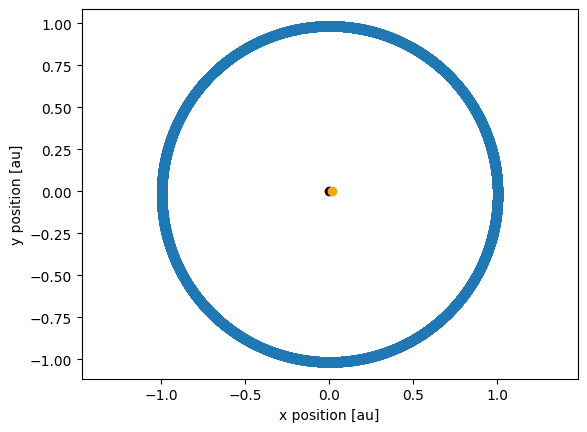

In [9]:
print("Mercury: a: {}; c:{}, e: {}".format(aMercury, cMercury, eMercury))
print("Venus: a: {}; c:{}, e: {}".format(aVenus, cVenus, eVenus))
print("Earth: a: {}; c:{}, e: {}".format(aEarth, cEarth, eEarth))
print("Mars: a: {}; c:{}, e: {}".format(aMars, cMars, eMars))
print("Jupiter: a: {}; c:{}, e: {}".format(aJupiter, cJupiter, eJupiter))
print("Moon: a: {}; c:{}, e: {}".format(aMoon, cMoon, eMoon))


plt.scatter(0,0, color='black') # true center
plt.scatter(cEarth,0, color='orange') # refBody position at one of the foci (c)
plt.scatter(xEarth,yEarth)
plt.axis('equal')
plt.xlabel('x position [au]')
plt.ylabel('y position [au]')
plt.show()

# Kepler 3rd Law

Use Kepler's Third Law to explore the relationship between orbital period and distance

In [10]:
def orbitalPeriod (distAU, mass1, mass2):
    return sqrt((4*pow(pi,2))/(pow(k,2)*(mass1+mass2)) * pow(distAU, 3))

In [11]:
# Use Constants
print("Mercury: {} au. P = {}".format(MERCURY_SUN_DIST, orbitalPeriod(MERCURY_SUN_DIST, SUN_MASS, MERCURY_MASS)))
print("Venus: {} au. P = {}".format(VENUS_SUN_DIST, orbitalPeriod(VENUS_SUN_DIST, SUN_MASS, VENUS_MASS)))
print("Earth: {} au. P = {}".format(EARTH_SUN_DIST, orbitalPeriod(EARTH_SUN_DIST, SUN_MASS, EARTH_MASS)))
print("Mars: {} au.  P = {}".format(MARS_SUN_DIST, orbitalPeriod(MARS_SUN_DIST, SUN_MASS, MARS_MASS)))
print("Jupiter: {} au.  P = {}".format(JUPITER_SUN_DIST, orbitalPeriod(JUPITER_SUN_DIST, SUN_MASS, JUPITER_MASS)))
print("Moon: {} au.  P = {}".format(MOON_EARTH_DIST, orbitalPeriod(MOON_EARTH_DIST, EARTH_MASS, MOON_MASS)))




Mercury: 0.3870320855614973 au. P = 87.94655783265084
Venus: 0.7232620320855615 au. P = 224.6680914785737
Earth: 1.0 au. P = 365.25635016675693
Mars: 1.5240641711229947 au.  P = 687.2317838065143
Jupiter: 5.203877005347594 au.  P = 4333.92955948361
Moon: 0.0025668449197860962 au.  P = 27.251409358962366


In [12]:
# Use Skyfield generated data
print("Mercury: {} au. P = {}".format(aMercury, orbitalPeriod(MERCURY_SUN_DIST, SUN_MASS, MERCURY_MASS)))
print("Venus: {} au. P = {}".format(aVenus, orbitalPeriod(aVenus, SUN_MASS, VENUS_MASS)))
print("Earth: {} au. P = {}".format(aEarth, orbitalPeriod(aEarth, SUN_MASS, EARTH_MASS)))
print("Mars: {} au.  P = {}".format(aMars, orbitalPeriod(aMars, SUN_MASS, MARS_MASS)))
print("Jupiter: {} au.  P = {}".format(aJupiter, orbitalPeriod(aJupiter, SUN_MASS, JUPITER_MASS)))
print("Moon: {} au.  P = {}".format(aMoon, orbitalPeriod(aMoon, EARTH_MASS, MOON_MASS)))


Mercury: 0.38565735915043753 au. P = 87.94655783265084
Venus: 0.72331235539094 au. P = 224.69153990487578
Earth: 1.0000226824346785 au. P = 365.2687775921827
Mars: 1.5225551571541136 au.  P = 686.2113684868934
Jupiter: 5.201943773598509 au.  P = 4331.514712240758
Moon: 0.002581338087530637 au.  P = 27.482539160448617
